In this assignment, you should implement and analize the kinematic model of vehicle. The model is a bicycle-like model and takes linear velocity and steering rate as inputs. Once the model is implemented, you should provide a set of inputs to drive it in a complex trajectory without any feedback control.
![title](img/bicycle_kinematics.jpg)
The bicycle kinematics are governed by the following set of equations:

\begin{align*}
\dot{x}_c &= v \cos{(\theta + \beta)} \\
\dot{y}_c &= v \sin{(\theta + \beta)} \\
\dot{\theta} &= \frac{v \cos{\beta} \tan{\delta}}{L} \\
\dot{\delta} &= \omega \\
\beta &= \tan^{-1}(\frac{l_r \tan{\delta}}{L})
\end{align*}

where the inputs are the bicycle speed $v$ and steering angle rate $\omega$. The input can also directly be the steering angle $\delta$ rather than its rate in the simplified case. The Python model will allow us both implementations.

In order to create this model, it's a good idea to make use of Python class objects. This allows us to store the state variables as well as make functions for implementing the bicycle kinematics. 

The bicycle begins with zero initial conditions, has a maximum turning rate of 1.22 rad/s, a wheelbase length of 2m, and a length of 1.2m to its center of mass from the rear axle.

From these conditions, we initialize the Python class as follows:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Bicycle():
    def __init__(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0
        
        self.L = 2
        self.lr = 1.2
        self.w_max = 1.22
        
        self.sample_time = 0.01
        
    def reset(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0

A sample time is required for numerical integration when propagating the kinematics through time. This is set to 10 milliseconds. We also have a reset function which sets all the state variables back to 0. 

With this sample time, implement the kinematic model using the function $\textit{step}$ defined in the next cell. The function should take speed + angular rate as inputs and update the state variables. Don't forget about the maximum turn rate on the bicycle!

In [2]:
class Bicycle(Bicycle):
    def step(self, v, w):
        # ==================================
        #  Implement kinematic model here
        # ==================================
        self.xc = self.xc + v * np.cos(self.theta + self.beta) * self.sample_time
        self.yc = self.yc + v * np.sin(self.theta + self.beta) * self.sample_time
        self.theta = self.theta + ((v * np.cos(self.beta) * np.tan(self.delta)/self.L)) * self.sample_time
        self.delta = w * self.sample_time + self.delta
        self.beta = np.arctan((self.lr / self.L) * np.tan(self.delta))
        
        pass



With the model setup, we can now start giving bicycle inputs and producing trajectories. 

Suppose we want the model to travel a circle of radius 10 m in 20 seconds. Using the relationship between the radius of curvature and the steering angle, the desired steering angle can be computed.

\begin{align*}
    \tan{\delta} &= \frac{L}{r} \\
    \delta &= \tan^{-1}(\frac{L}{r}) \\
           &= \tan^{-1}(\frac{2}{10}) \\
           &= 0.1974
\end{align*}

If the steering angle is directly set to 0.1974 using a simplied bicycled model, then the bicycle will travel in a circle without requiring any additional steering input. 

The desired speed can be computed from the circumference of the circle:

\begin{align*}
    v &= \frac{d}{t}\\
     &= \frac{2 \pi 10}{20}\\
     &= \pi
\end{align*}

We can now implement this in a loop to step through the model equations. We will also run our bicycle model solution along with your model to show you the expected trajectory. This will help you verify the correctness of your model.

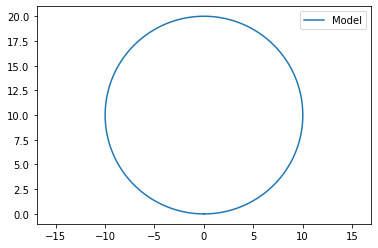

In [3]:
sample_time = 0.01
time_end = 20
model = Bicycle()

# set delta directly
model.delta = np.arctan(2/10)

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(np.pi, 0)
    
    model.beta = 0
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Model')
plt.legend()
plt.show()

The plot above shows the desired circle of 10m radius. The path is slightly offset which is caused by the sideslip effects due to $\beta$. By forcing $\beta = 0$ through uncommenting the last line in the loop, you can see that the offset disappears and the circle becomes centered at (0,10). 

However, in practice the steering angle cannot be directly set and must be changed through angular rate inputs $\omega$. The cell below corrects for this and sets angular rate inputs to generate the same circle trajectory. The speed $v$ is still maintained at $\pi$ m/s.

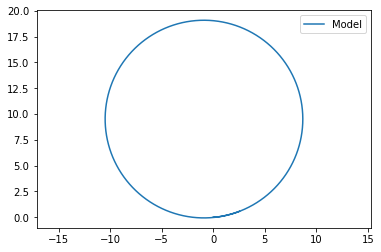

In [4]:
sample_time = 0.01
time_end = 20
model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    
    if model.delta < np.arctan(2/10):
        model.step(np.pi, model.w_max)
    else:
        model.step(np.pi, 0)
        
plt.axis('equal')
plt.plot(x_data, y_data,label='Model')
plt.legend()
plt.show()

Here are some other example trajectories: a square path, a spiral path, and a wave path. Uncomment each section to view.

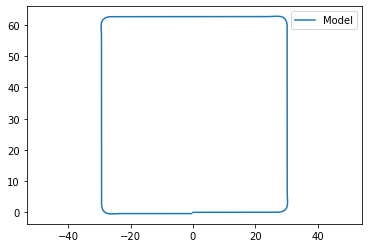

In [5]:
# sample_time = 0.01
time_end = 60
model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

# maintain velocity at 4 m/s
v_data = np.zeros_like(t_data)
v_data[:] = 4 

w_data = np.zeros_like(t_data)

# ==================================
#  Square Path: set w at corners only
# ==================================
w_data[670:670+100] = 0.753
w_data[670+100:670+100*2] = -0.753
w_data[2210:2210+100] = 0.753
w_data[2210+100:2210+100*2] = -0.753
w_data[3670:3670+100] = 0.753
w_data[3670+100:3670+100*2] = -0.753
w_data[5220:5220+100] = 0.753
w_data[5220+100:5220+100*2] = -0.753

# ==================================
#  Spiral Path: high positive w, then small negative w
# ==================================
# w_data[:] = -1/100
# w_data[0:100] = 1

# ==================================
#  Wave Path: square wave w input
# ==================================
# w_data[:] = 0
# w_data[0:100] = 1
# w_data[100:300] = -1
# w_data[300:500] = 1
# w_data[500:5700] = np.tile(w_data[100:500], 13)
# w_data[5700:] = -1

# ==================================
#  Step through bicycle model
# ==================================
for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Model')
plt.legend()
plt.show()

We would now like the bicycle to travel a complex trajectory. The circle in the figure has a radius of 8m, the square has a diagonal of 16m and the path should complete in 30 seconds. The path begins at the bottom of the circle and is shown in the figure below:

![title](img/comp_fig.jpg)

Determine the speed and steering rate inputs required to produce such trajectory and implement in the cell below. Make sure to also save your inputs into the arrays v_data and w_data, these will be used to grade your solution. The cell below also plots the trajectory generated by your model.

1881
1 delta:  0.25619999999999993
2 delta:  -0.09759999999999998
-0.006776385684595205 2716 856
-0.0016007894989625761 2717 857
0.003574806686670053 2718 858
0.008750402872302682 2719 859


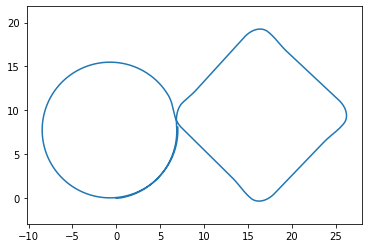

In [6]:
sample_time = 0.01
time_end = 30
model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# ==================================
#  Your solution begins here
# ==================================
v_data[:] = np.pi

t_sirc = int(np.ceil((np.arctan(1/4) / model.w_max) / sample_time))
w_data[:t_sirc] = model.w_max

shift = -20
t_quater = int(np.ceil(4 / sample_time))
w_data[t_quater- t_sirc:t_quater] = -model.w_max

v_data[t_quater:] = 4

shift0 = 53 #39--55
w_data[t_quater:t_quater+shift0] = -model.w_max
w_data[t_quater+shift0:t_quater+shift0*2] = model.w_max


forward_len = 200
t_start = t_quater+shift0*2+ forward_len
shift = 78
w_data[t_start:t_start+shift] = -model.w_max
w_data[t_start+shift:t_start+shift*2] = model.w_max

t_start += shift*2 + forward_len
w_data[t_start:t_start+shift] = -model.w_max
w_data[t_start+shift:t_start+shift*2] = model.w_max

t_start += shift*2 + forward_len
w_data[t_start:t_start+shift] = -model.w_max
w_data[t_start+shift:t_start+shift*2] = model.w_max


shift1 = 43
sm_shift = 0
t_start += shift*2 + forward_len
w_data[t_start+sm_shift:t_start+shift1+sm_shift] = -model.w_max
w_data[t_start+shift1+sm_shift:t_start+shift1*2+sm_shift] = model.w_max

t_start += sm_shift+shift1*2
w_data[t_start:t_start+t_sirc] = model.w_max
print(t_start + t_sirc)


# print(t_sirc, t_quater)
# print("pi", math.pi, math.pi/2, math.pi/4)
dtheta = np.pi/2 - np.pi/4
# print('dtheta', dtheta, dtheta/2)

is_was = True
is_was2 = True
c = 0.0
# print("theta: ", model.theta)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    
    if i > t_start and abs(model.theta) < 0.01:
        print(model.theta, i, i-t_start)
    model.step(v_data[i], w_data[i])
    if i == 1851:
        print('2 delta: ', model.delta)
    if i == t_sirc:
        print('1 delta: ', model.delta)    

# ==================================
#  Your solution ends here
# ==================================
plt.axis('equal')
plt.plot(x_data, y_data)
plt.show()

The cell below will save the time and vehicle inputs as text file named $\textit{complex_figure.txt}$. Please, attach your Jupyter Notebook file and text file as a result in Moodle.


In [7]:
data = np.vstack([t_data, v_data, w_data]).T
np.savetxt('complex_figure.txt', data, delimiter=', ')

Congratulations! You have now completed the assignment! Feel free to test the bicycle model with different inputs in the cell below, and see what trajectories they form. For example, try moving in an equilateral triangle. You'll find that it's rather difficult to generate desired trajectories by pre-setting the inputs.